DEMO: Approximating f(z) = tan(πz/2) on a spiral
Converged at iteration 12 with error 1.15e-13

Convergence history:
  m =  1: error = 2.49e+01
  m =  2: error = 4.28e+01
  m =  3: error = 1.71e+01
  m =  4: error = 8.65e-02
  m =  5: error = 1.27e-02
  m =  6: error = 9.91e-04
  m =  7: error = 5.87e-05
  m =  8: error = 1.29e-06
  m =  9: error = 3.57e-08
  m = 10: error = 6.37e-10
  m = 11: error = 1.67e-11
  m = 12: error = 1.15e-13

Number of support points: 12

Pole comparison:
   True Pole                  Computed Pole        Error
-------------------------------------------------------
         1.0   1.0000000000 -0.0000000000i     8.95e-16
        -1.0  -1.0000000000 +0.0000000000i     2.54e-16
         3.0   3.0000001004 -0.0000000409i     1.08e-07
        -3.0  -3.0000000647 -0.0000000582i     8.70e-08
         5.0   5.0026932457 -0.0005617593i     2.75e-03
        -5.0  -5.0024386920 -0.0007471458i     2.55e-03


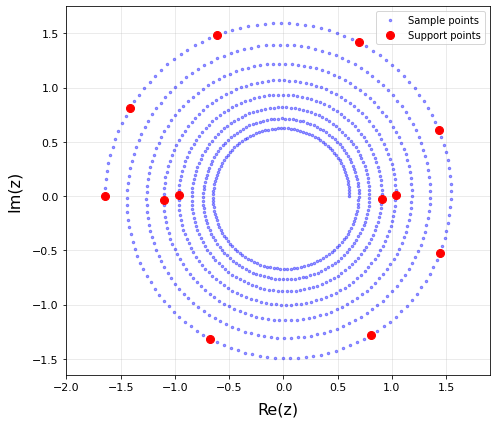

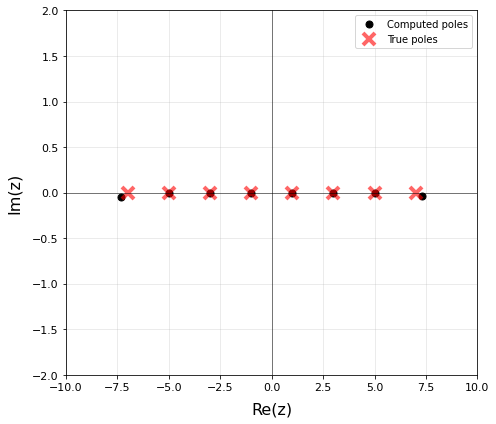

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import svd, eig

class AAAApproximation:
    """
    A simple implementation of the AAA (Adaptive Antoulas-Anderson) algorithm
    for rational approximation.
    """
    
    def __init__(self, tol=1e-13, max_iter=100):
        self.tol = tol
        self.max_iter = max_iter
        self.z_support = []
        self.f_support = []
        self.weights = None
        self.errors = []
        
    def fit(self, Z, F):
        """Fit the AAA approximant to data."""
        Z = np.asarray(Z, dtype=complex)
        F = np.asarray(F, dtype=complex)
        M = len(Z)
        
        # Initialize
        J = np.arange(M)
        self.z_support = []
        self.f_support = []
        self.errors = []
        
        # Mean value as initial approximation
        R = np.full(M, np.mean(F), dtype=complex)
        
        for m in range(1, min(self.max_iter + 1, M // 2 + 1)):
            # Greedy selection
            residuals = np.abs(F[J] - R[J])
            j_rel = np.argmax(residuals)
            j_max = J[j_rel]
            
            # Add new support point
            self.z_support.append(Z[j_max])
            self.f_support.append(F[j_max])
            J = np.delete(J, j_rel)
            
            if len(J) == 0:
                break
            
            # Build matrices
            z_support_array = np.array(self.z_support)
            f_support_array = np.array(self.f_support)
            
            C = 1.0 / (Z[J, None] - z_support_array[None, :])
            SF = np.diag(F[J])
            Sf = np.diag(f_support_array)
            A = SF @ C - C @ Sf
            
            # SVD
            try:
                _, sigma, Vh = svd(A, full_matrices=False)
                self.weights = Vh[-1, :].conj()
            except:
                print(f"SVD failed at iteration {m}")
                break
            
            # Compute approximation
            N = C @ (self.weights * f_support_array)
            D = C @ self.weights
            
            mask = np.abs(D) > 1e-15
            R_new = np.full(len(J), np.nan, dtype=complex)
            R_new[mask] = N[mask] / D[mask]
            R_new[~mask] = R[J][~mask]
            R[J] = R_new
            
            # Exact values at support points
            for zs, fs in zip(self.z_support, self.f_support):
                support_idx = np.where(np.abs(Z - zs) < 1e-14)[0]
                if len(support_idx) > 0:
                    R[support_idx[0]] = fs
            
            # Error
            err = np.max(np.abs(F - R))
            self.errors.append(err)
            
            if err <= self.tol * np.max(np.abs(F)):
                print(f"Converged at iteration {m} with error {err:.2e}")
                break
        
        return self
    
    def __call__(self, z):
        """Evaluate the rational approximant."""
        z = np.asarray(z, dtype=complex)
        original_shape = z.shape
        z = z.ravel()
        
        if self.weights is None or len(self.z_support) == 0:
            return np.full_like(z, np.nan)
        
        w_array = np.array(self.weights)
        f_array = np.array(self.f_support)
        z_array = np.array(self.z_support)
        
        C = 1.0 / (z[:, None] - z_array[None, :])
        N = C @ (w_array * f_array)
        D = C @ w_array
        
        r = np.full(len(z), np.nan, dtype=complex)
        mask = np.abs(D) > 1e-15
        r[mask] = N[mask] / D[mask]
        
        # Interpolation at support points
        for i, zi in enumerate(z):
            for j, zj in enumerate(z_array):
                if np.abs(zi - zj) < 1e-14:
                    r[i] = f_array[j]
                    break
        
        return r.reshape(original_shape)
    
    def poles(self):
        """Compute poles using arrowhead eigenvalue problem."""
        if self.weights is None or len(self.weights) == 0:
            return np.array([])
        
        m = len(self.weights)
        w_array = np.array(self.weights)
        z_array = np.array(self.z_support)
        
        # Arrowhead matrices
        A = np.zeros((m + 1, m + 1), dtype=complex)
        A[0, 1:] = w_array
        A[1:, 0] = 1.0
        A[1:, 1:] = np.diag(z_array)
        
        B = np.eye(m + 1, dtype=complex)
        B[0, 0] = 0.0
        
        try:
            eigvals, _ = eig(A, B)
            finite_mask = np.isfinite(eigvals) & (np.abs(eigvals) < 1e10)
            return eigvals[finite_mask]
        except:
            return np.array([])
    
    def zeros(self):
        """Compute zeros of the numerator."""
        if self.weights is None or len(self.weights) == 0:
            return np.array([])
        
        m = len(self.weights)
        w_array = np.array(self.weights)
        f_array = np.array(self.f_support)
        z_array = np.array(self.z_support)
        
        # Same arrowhead structure but with w_j * f_j
        A = np.zeros((m + 1, m + 1), dtype=complex)
        A[0, 1:] = w_array * f_array
        A[1:, 0] = 1.0
        A[1:, 1:] = np.diag(z_array)
        
        B = np.eye(m + 1, dtype=complex)
        B[0, 0] = 0.0
        
        try:
            eigvals, _ = eig(A, B)
            finite_mask = np.isfinite(eigvals) & (np.abs(eigvals) < 1e10)
            return eigvals[finite_mask]
        except:
            return np.array([])



def demo_spiral():
    """
    Reproduce Figure 4.3: approximation of tan(πz/2) on a spiral.
    """
    print("=" * 70)
    print("DEMO: Approximating f(z) = tan(πz/2) on a spiral")
    print("=" * 70)
    
    # Spiral parameterization
    n_points = 1000
    t = np.linspace(-0.5, 0.5 + 1j * 15 * np.pi, n_points)
    Z = np.exp(t)
    
    # Function to approximate
    F = np.tan(np.pi * Z / 2)
    
    # Fit AAA
    aaa = AAAApproximation(tol=1e-13, max_iter=100)
    aaa.fit(Z, F)
    
    # Print results
    print(f"\nConvergence history:")
    for i, err in enumerate(aaa.errors[:15], 1):
        print(f"  m = {i:2d}: error = {err:.2e}")
    
    print(f"\nNumber of support points: {len(aaa.z_support)}")
    
    # Poles
    computed_poles = aaa.poles()
    true_poles = np.array([1, -1, 3, -3, 5, -5, 7, -7])
    
    print(f"\nPole comparison:")
    print(f"{'True Pole':>12} {'Computed Pole':>30} {'Error':>12}")
    print("-" * 55)
    
    for tp in true_poles[:6]:
        distances = np.abs(computed_poles - tp)
        if len(distances) > 0:
            idx = np.argmin(distances)
            cp = computed_poles[idx]
            error = np.abs(cp - tp)
            print(f"{tp:12.1f} {cp.real:14.10f}{cp.imag:+14.10f}i {error:12.2e}")
    
    # --------------------------
    # Left plot: Sample & support points
    # --------------------------
    fig, ax = plt.subplots(figsize=(7,6))
    ax.plot(Z.real, Z.imag, 'b.', markersize=5, alpha=0.4, label='Sample points')
    z_sup = np.array(aaa.z_support)
    ax.plot(z_sup.real, z_sup.imag, 'ro', markersize=8, label='Support points', zorder=5)
    ax.set_xlabel('Re(z)', fontsize=16, labelpad=10)
    ax.set_ylabel('Im(z)', fontsize=16, labelpad=10)
    ax.tick_params(axis='both', which='major', labelsize=11) 
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.axis('equal')
    plt.tight_layout()
    plt.savefig('C:\\Users\\asus\\Downloads\\aaa_sample_support.pdf', dpi=300, bbox_inches='tight')
    plt.show()
    
    # --------------------------
    # Right plot: Poles
    # --------------------------
    fig, ax = plt.subplots(figsize=(7,6))
    poles = aaa.poles()
    ax.plot(poles.real, poles.imag, 'k.', markersize=14, label='Computed poles')
    ax.plot(true_poles, np.zeros_like(true_poles), 'rx', 
            markersize=12, markeredgewidth=4, alpha=0.6, label='True poles')
    ax.set_xlabel('Re(z)', fontsize=16, labelpad=10)
    ax.set_ylabel('Im(z)', fontsize=16, labelpad=10)
    ax.tick_params(axis='both', which='major', labelsize=11) 
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color='k', linewidth=0.5)
    ax.axvline(x=0, color='k', linewidth=0.5)
    ax.set_xlim(-10, 10)
    ax.set_ylim(-2, 2)
    plt.tight_layout()
    plt.savefig('C:\\Users\\asus\\Downloads\\aaa_poles.pdf', dpi=300, bbox_inches='tight')
    plt.show()


if __name__ == "__main__":
    demo_spiral()
   
